In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [ ]:
df = pd.read_csv("fire_archive.csv")

In [3]:
df.shape

(36011, 15)

In [4]:
df.isnull().sum()

latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64

/tmp/ipykernel_36963/1939481835.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="viridis")


<AxesSubplot: >

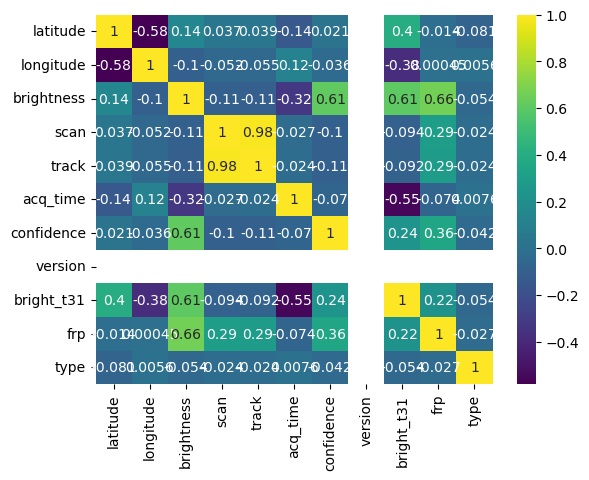

In [5]:
sns.heatmap(df.corr(), annot=True, cmap="viridis")

# Preprocess

In [6]:
df = df.drop(["instrument", "version", "track"], axis=1)

In [7]:
df["satellite"].value_counts()

Aqua     20541
Terra    15470
Name: satellite, dtype: int64

In [8]:
df["daynight"].value_counts()

D    28203
N     7808
Name: daynight, dtype: int64

In [9]:
df["type"].value_counts()

0    35666
2      335
3       10
Name: type, dtype: int64

In [10]:
le = LabelEncoder().fit(df["satellite"])
le_nm = dict(zip(le.classes_, le.transform(le.classes_)))
df["satellite"] = df["satellite"].apply(lambda x: le_nm[x])

In [11]:
le_nm

{'Aqua': 0, 'Terra': 1}

In [12]:
le2 = LabelEncoder().fit(df["daynight"])
le_nm2 = dict(zip(le2.classes_, le2.transform(le2.classes_)))
df["daynight"] = df["daynight"].apply(lambda x: le_nm2[x])

In [13]:
le_nm2

{'D': 0, 'N': 1}

In [14]:
types = pd.get_dummies(df["type"])
types.head()

,0,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [15]:
types = types.rename(columns={0: "Type0", 2: "Type2", 3: "Type3"})

In [16]:
df = pd.concat([df, types], axis=1)

In [17]:
df = df.drop(["type", "Type0"], axis=1)

In [18]:
df["scan"].value_counts()

1.0    8284
1.1    6000
1.2    3021
1.3    2412
1.4    1848
1.5    1610
1.6    1451
1.7    1281
1.8    1041
1.9     847
2.0     707
2.2     691
2.1     649
2.3     608
2.5     468
2.4     433
2.8     422
3.0     402
2.7     366
2.9     361
2.6     347
3.1     259
3.2     244
3.6     219
3.4     203
3.3     203
3.8     189
3.9     156
4.7     149
4.3     137
3.7     134
3.5     134
4.1     120
4.6     118
4.5     116
4.2     108
4.0     103
4.4     100
4.8      70
Name: scan, dtype: int64

In [19]:
df["scan"] = pd.cut(df["scan"], bins=[0,1,2,3,4,5], labels=[1,2,3,4,5])

In [20]:
df["acq_date"] = pd.to_datetime(df["acq_date"])
df["day"] = df["acq_date"].dt.day
df["month"] = df["acq_date"].dt.month
df["year"] = df["acq_date"].dt.year

In [21]:
df = df.drop(["acq_date", "acq_time", "bright_t31"], axis=1)

In [22]:
X = df.drop(["confidence"], axis=1)
y = df["confidence"]

/tmp/ipykernel_36963/744345980.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X.corr(), annot=True, cmap="viridis")


<AxesSubplot: >

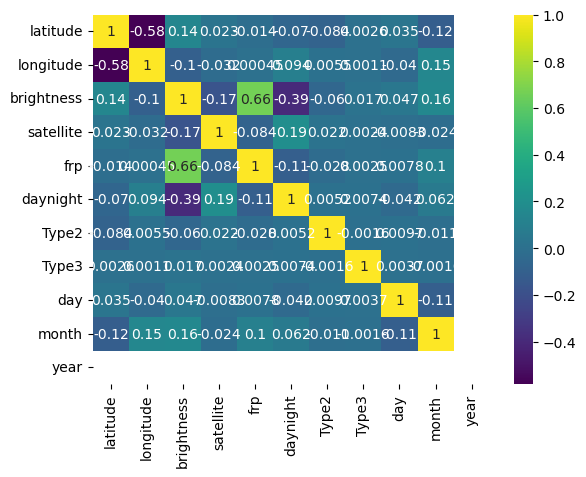

In [23]:
sns.heatmap(X.corr(), annot=True, cmap="viridis")

In [24]:
X.shape

(36011, 12)

In [25]:
y.shape

(36011,)

# Model Training

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :1000], y, test_size=0.2, random_state=4242)

In [29]:
rf_model = RandomForestRegressor().fit(X_train, y_train)

In [33]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [30]:
y_pred = rf_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

13.433260499890572

In [31]:
acc = round(rf_model.score(X_test, y_test) * 100, 2)
acc

66.57

# Model Tuning

In [ ]:
rf_params = {'max_depth': list(range(10, 20)), 
             'max_features': [5, 10, 20], 
             'n_estimators': [100, 250, 500]}
rf_model = RandomForestRegressor()
rf_cv_model = GridSearchCV(rf_model, rf_params, cv=10, n_jobs=-1).fit(X_train, y_train)
rf_cv_model.best_params_

In [35]:
rf_tuned = RandomForestRegressor(max_depth=8, max_features=5, n_estimators=100).fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

14.260665014187392

In [36]:
cc = round(rf_tuned.score(X_test, y_test) * 100, 2)
acc

66.57

In [37]:
model = pickle.dump(rf_tuned, open("RandomForest.pickle", "wb"))

In [39]:
y_test.shape, y_pred.shape

((7203,), (7203,))